# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1

Importing data from Google Drive folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

As usual, let us first import the needed Python libraries:

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

Let us load a train image:

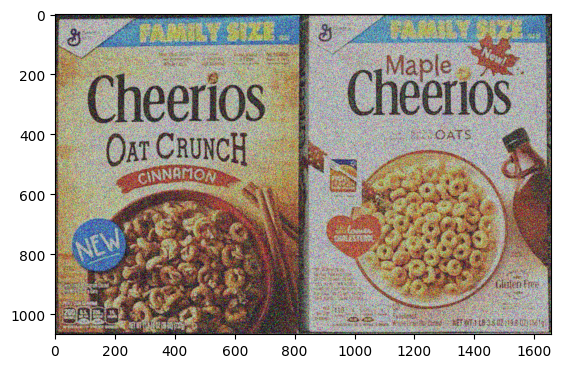

In [44]:
image = cv2.imread('dataset/scenes/scene1.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.show()

We apply a Median filter to remove salt-and-pepper noise.

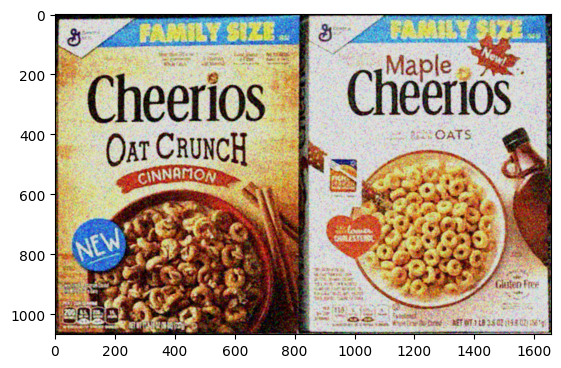

In [45]:
filtered_image = cv2.medianBlur(image_rgb, 5)
plt.imshow(filtered_image)
plt.show()

We use the Non-local means algorithm

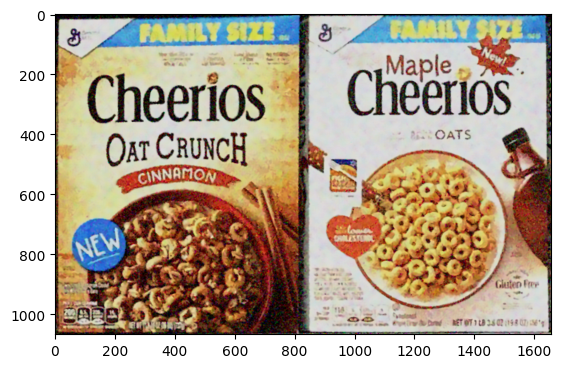

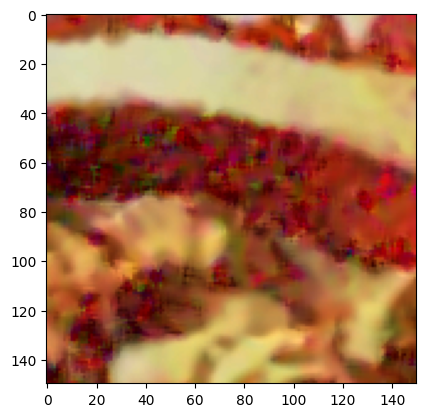

In [46]:
filtered_image = cv2.fastNlMeansDenoisingColored(filtered_image, None, 10, 10, 7, 21)
plt.imshow(filtered_image)
plt.show()
plt.imshow(filtered_image[550:700, 400:550])
plt.show()

Equalize histogram

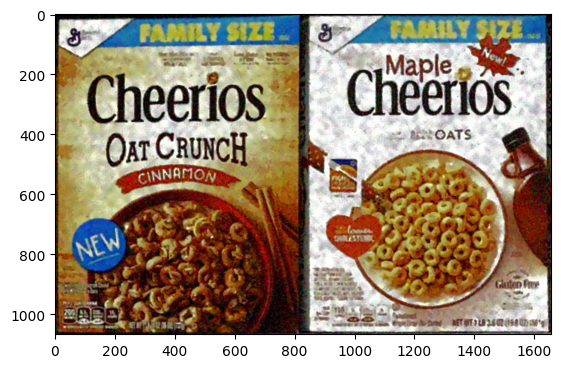

In [47]:
img_yuv = cv2.cvtColor(filtered_image, cv2.COLOR_RGB2YUV)

# equalize the histogram of the Y channel
img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

# convert the YUV image back to RGB format
filtered_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

plt.imshow(filtered_image)
plt.show()

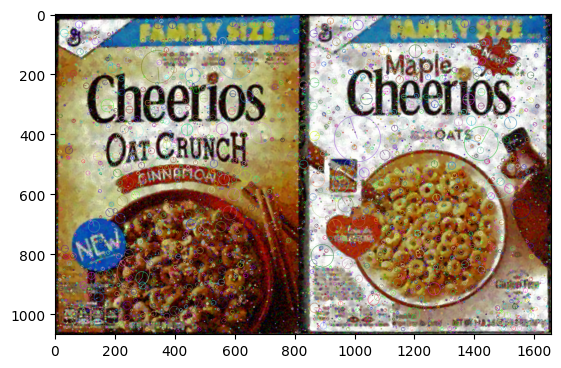

In [48]:
sift = cv2.xfeatures2d.SIFT_create()
kp_train = sift.detect(filtered_image)

img_visualization = cv2.drawKeypoints(filtered_image, kp_train, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_visualization)
plt.show()

In [ ]:
directory = "scenes_filtered"
if not os.path.exists(directory):
    os.makedirs(directory)

We iterate the process for all the scene images.

In [49]:
for i in range(12):
  image = cv2.imread('dataset/scenes/scene' + str(i+1) + '.png')
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  filtered_image = cv2.medianBlur(image_rgb, 5)
  filtered_image = cv2.fastNlMeansDenoisingColored(filtered_image, None, 10, 10, 7, 21)
  img_yuv = cv2.cvtColor(filtered_image, cv2.COLOR_RGB2YUV)
  img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
  filtered_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
  copied_image_bgr = cv2.cvtColor(filtered_image, cv2.COLOR_RGB2BGR)
  cv2.imwrite('scenes_filtered/scene' + str(i+1) + '.png', copied_image_bgr)

Let us load a query image:

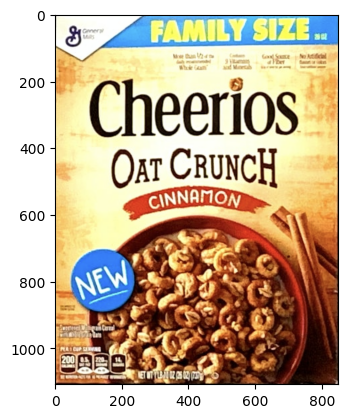

In [ ]:
img_query = cv2.imread('dataset/models/ref1.png')
img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)

plt.imshow(img_query)
plt.show()

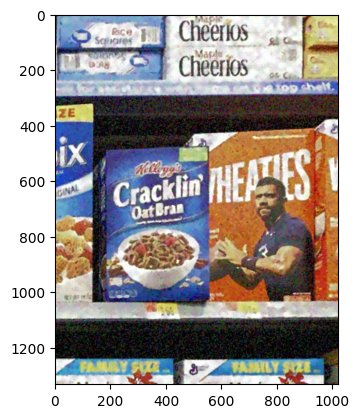

In [52]:
from imutils.object_detection import non_max_suppression
import imutils

imgs_train = ['scenes_filtered/scene5.png']

template = cv2.imread('dataset/models/ref12.png', cv2.IMREAD_GRAYSCALE)
assert template is not None, "file could not be read, check with os.path.exists()"
w, h = template.shape[::-1]

threshold = 0.7

# ref12, ref16, ref17, ref18

# Iterating among all images and looking for the query object.
for path in imgs_train:
  img = cv2.imread(path)
  assert img is not None, "file could not be read, check with os.path.exists()"
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  w_img, h_img = img_gray.shape[::-1]
  # loop over the scales of the image
  for scale in np.linspace(0.1, 1.0, 40):
		# resize the image according to the scale, and keep track
		# of the ratio of the resizing
    resized = imutils.resize(template, width = int(template.shape[1] * scale))
    r = template.shape[1] / float(resized.shape[1])
		# if the resized image is smaller than the template, then break
		# from the loop
    if resized.shape[0] > h_img or resized.shape[1] > w_img:
      break

    res = cv2.matchTemplate(img_gray, resized, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= threshold)

    for pt in zip(*loc[::-1]):
      cv2.rectangle(img_rgb, pt, (pt[0] + int(w/r), pt[1] + int(h/r)), (0,0,255), 2)

  plt.imshow(img_rgb)
  plt.show()

In [58]:
# Define a function for object detection pipeline
def object_retrieve(img_query, img_train, min_match_count):

    sift = cv2.xfeatures2d.SIFT_create()
    kp_query = sift.detect(img_query)
    kp_train = sift.detect(img_train)
    kp_query, des_query = sift.compute(img_query, kp_query)
    kp_train, des_train = sift.compute(img_train, kp_train)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des_query,des_train,k=2)

    good = []
    for m,n in matches:
      if m.distance < 0.75*n.distance:
        good.append(m)

    print("Number of good matches:", len(good))

    if len(good)>min_match_count:
      # building the corrspondences arrays of good matches
      src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
      dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

      # Using RANSAC to estimate a robust homography.
      # It returns the homography M and a mask for the discarded points
      M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

      # Mask of discarded point used in visualization
      matchesMask = mask.ravel().tolist()

      # Corners of the query image
      h,w = img_query.shape[:2]
      pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

      # Projecting the corners into the train image
      dst = cv2.perspectiveTransform(pts,M)

      # Drawing the bounding box
      img_train_p = cv2.polylines(img_train,[np.int32(dst)],True,255,3, cv2.LINE_AA)

      plt.imshow(img_train_p)
      plt.show()
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), min_match_count) )
        matchesMask = None

    return len(good) > min_match_count

imgs_train = ['scenes_filtered/scene1.png', 'scenes_filtered/scene2.png', 'scenes_filtered/scene3.png', 'scenes_filtered/scene4.png', 'scenes_filtered/scene5.png']
img_query = cv2.imread('dataset/models/ref2.png')
img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)

# Iterating among all images and looking for the query object.
for path in imgs_train:
    img_train = cv2.imread(path)
    img_train = cv2.cvtColor(img_train, cv2.COLOR_BGR2RGB)
    found = object_retrieve(img_query, img_train, 50)
    print("Found query object in {}:{}".format(path,found > 0))

Output hidden; open in https://colab.research.google.com to view.